In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [20]:
#Importing Data

df = pd.read_csv('../data/interim/radius3_selected_features.csv',index_col=[0])
X = df.drop(['Gini index','Country Name'],axis=1).to_numpy()

y = df['Gini index'].to_numpy()
groups = df['Country Name'].to_numpy()


#preprocessing pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

preprocess_steps = [('scaler',StandardScaler()),
                    ('ct',ColumnTransformer([('pca',PCA(n_components=2),list(range(13,19)))],remainder='passthrough'))]


#Setting up cross-validation
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)

#Setting up model
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

params = {'reg_lambda': 1.2000000000000002,
 'reg_alpha': 0.2,
 'n_estimators': 115,
 'max_depth': 2,
 'learning_rate': 0.4}

model = Pipeline(steps=preprocess_steps + [('xgb',XGBRegressor(**params))])


#Feature Names
columns = df.drop(['Country Name', 'Gini index'],axis=1).columns.to_list()
feature_names = [col for col in columns if col.find('Poverty') < 0]

feature_names = ['poverty_pca0','poverty_pca1'] + feature_names

In [ ]:
from sklearn.feature_selection import RFE




In [21]:
folds = gkf.split(X,y,groups=groups)
feature_importances = {}
for f in feature_names:
    feature_importances[f] = []

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
    model.fit(X_train,y_train)

    fold_fi = model.named_steps['xgb'].feature_importances_
    
    for j in range(len(feature_names)):
        feature_importances[feature_names[j]].append(fold_fi[j])

<Axes: >

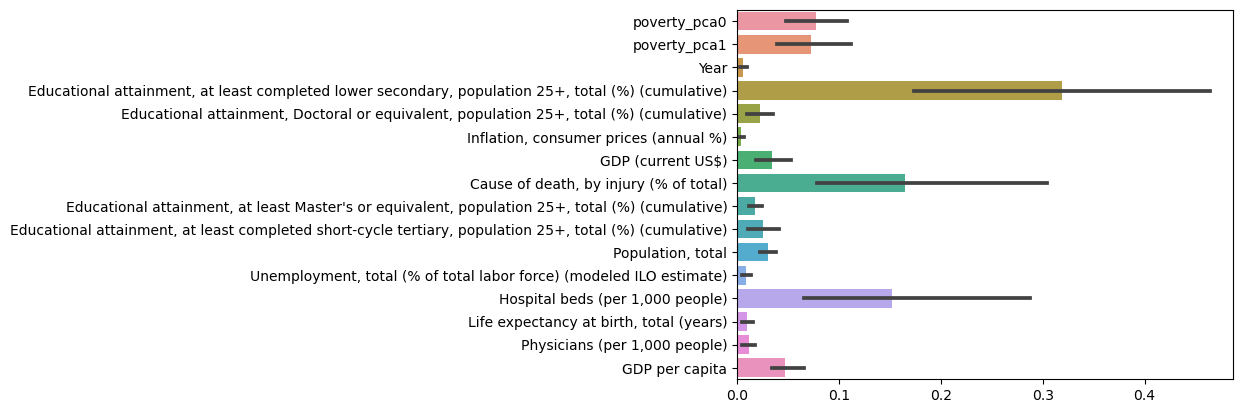

In [22]:
sns.barplot(pd.DataFrame(feature_importances),orient='h')

In [7]:
from sklearn.inspection import permutation_importance

folds = gkf.split(X,y,groups=groups)
permutation_importances = {}
for f in feature_names:
    permutation_importances[f] = []

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]

    preprocessor = Pipeline(steps=preprocess_steps)
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    xgb = XGBRegressor(**params)
    xgb.fit(X_train,y_train)
    perm = permutation_importance(xgb,X_test, y_test, random_state=1)
    fold_pi = perm.importances_mean # type: ignore
    for j in range(len(feature_names)):
        permutation_importances[feature_names[j]].append(fold_pi[j])

<Axes: >

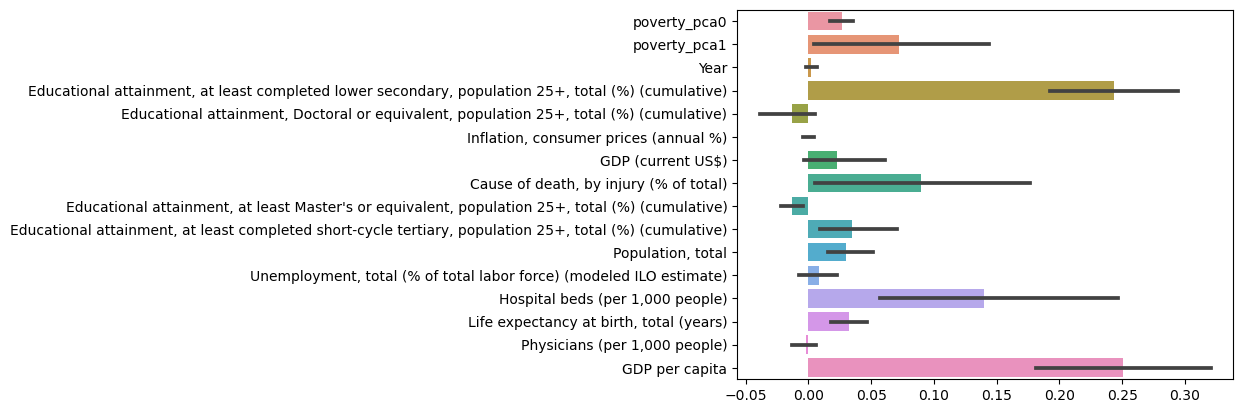

In [9]:
sns.barplot(pd.DataFrame(permutation_importances),orient='h')

In [12]:
df.head()

,Year,"Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)","Educational attainment, Doctoral or equivalent, population 25+, total (%) (cumulative)","Inflation, consumer prices (annual %)",GDP (current US$),"Cause of death, by injury (% of total)","Educational attainment, at least Master's or equivalent, population 25+, total (%) (cumulative)","Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)","Population, total","Unemployment, total (% of total labor force) (modeled ILO estimate)",...,"Physicians (per 1,000 people)",Country Name,Gini index,Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population),Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),Poverty gap at $2.15 a day (2017 PPP) (%),Poverty gap at $3.65 a day (2017 PPP) (%),Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Poverty gap at $6.85 a day (2017 PPP) (%),GDP per capita
11420,2002,88.543221,0.00000,0.757421,4.395616e+10,8.507397,16.28310,38.141708,48202470.0,10.140,...,3.0188,Ukraine,29.0,17.0,61.9,0.5,3.7,2.7,20.8,911.906871
11686,2003,88.543221,0.00000,5.179678,5.201035e+10,8.507397,16.28310,38.141708,47812949.0,9.060,...,3.0096,Ukraine,28.7,10.4,54.1,0.2,2.1,1.1,16.0,1087.788007
12624,2007,95.692841,0.03193,10.230103,3.802571e+09,10.150055,15.44759,17.622650,5268400.0,2.677,...,2.3580,Kyrgyz Republic,33.9,33.6,74.2,1.7,9.5,8.8,31.8,721.769526
12687,2007,61.490292,0.25529,4.168633,2.129598e+10,12.359977,2.37209,21.358910,3431614.0,5.844,...,1.3032,Panama,52.7,14.9,30.5,2.2,5.7,6.7,13.6,6205.821576
12879,2008,80.522840,0.79249,4.060305,2.754475e+11,5.055017,9.20796,30.182824,4489544.0,6.770,...,4.0144,Ireland,30.9,0.3,0.8,0.1,0.2,0.2,0.4,61353.106563


86


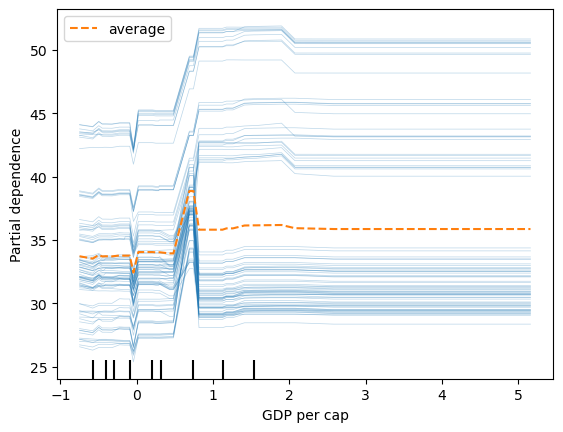

86


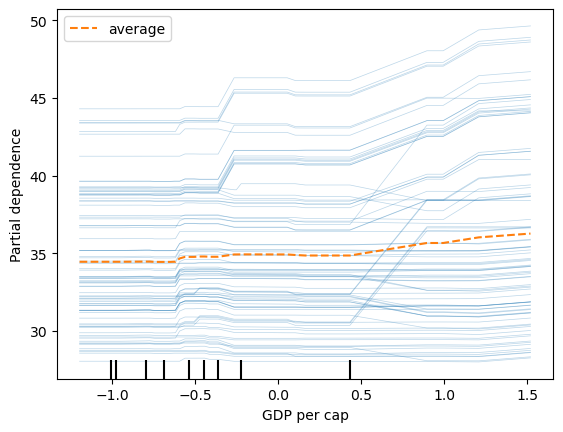

86


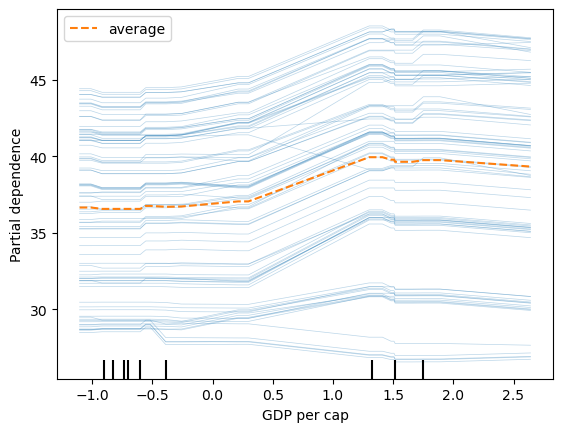

86


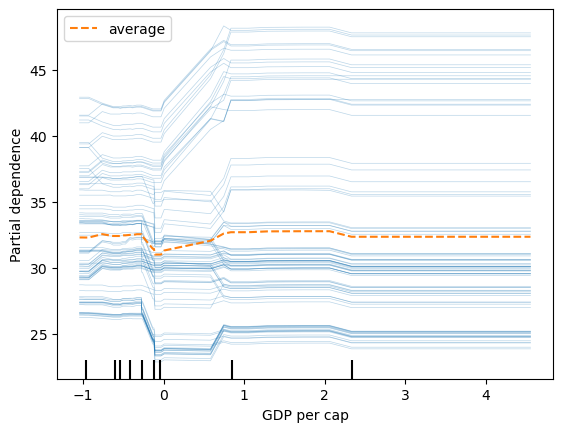

85


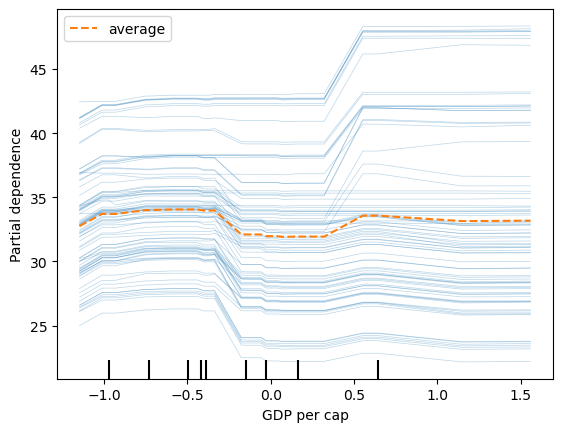

In [18]:
from sklearn.inspection import PartialDependenceDisplay

folds = gkf.split(X,y,groups=groups)

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]

    preprocessor = Pipeline(steps=preprocess_steps)
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    xgb = XGBRegressor(**params)
    xgb.fit(X_train,y_train)
    print(len(X_test))
    disp3 = PartialDependenceDisplay.from_estimator(xgb, X_test, [7],kind='both')
    plt.xlabel('GDP per cap')
    plt.show()


* SHAP values
* PDPs
* countries expected vs actual gini index